# Prepare Environment

In [1]:
import numpy as np
import pandas as pd
import math, copy
import matplotlib
import matplotlib.pyplot as plt

font = {'size' : 18}
matplotlib.rc('font', **font)

np.set_printoptions(precision=3)  # reduced display precision on numpy arrays

# Dataset

Suppose you are starting a company that grows and sells wild mushrooms. 
- Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes
- You have some existing data that you can use for this task. 

Can you use the data to help you identify which mushrooms can be sold safely?

Suppose that you have 10 examples of mushrooms as follows:

| Cap Color | Stalk Shape | Solitary | Edible |
|:---------:|:-----------:|:--------:|:------:|
|   Brown   |   Tapering  |    Yes   |    1   |
|   Brown   |  Enlarging  |    Yes   |    1   |
|   Brown   |  Enlarging  |    No    |    0   |
|   Brown   |  Enlarging  |    No    |    0   |
|   Brown   |   Tapering  |    Yes   |    1   |
|    Red    |   Tapering  |    Yes   |    0   |
|    Red    |  Enlarging  |    No    |    0   |
|   Brown   |  Enlarging  |    Yes   |    1   |
|    Red    |   Tapering  |    No    |    1   |
|   Brown   |  Enlarging  |    No    |    0   |

For each example, you have
    - Three features
        - Cap Color (`Brown` or `Red`),
        - Stalk Shape (`Tapering` or `Enlarging`), and
        - Solitary (`Yes` or `No`)
    - Label
        - Edible (`1` indicating yes or `0` indicating poisonous)

Note: The dataset used is for illustrative purposes only. It is not meant to be a guide on identifying edible mushrooms.

Source: The dataset used in this lab exercise is partly from Coursera - [Machine Learning Specialization](https://www.coursera.org/specializations/machine-learning-introduction)

In [2]:
X = np.array([
    ['Brown','Tapering','Yes'],
    ['Brown','Enlarging','Yes'],
    ['Brown','Enlarging','No'],
    ['Brown','Enlarging','No'],
    ['Brown','Tapering','Yes'],
    ['Red','Tapering','Yes'],
    ['Red','Enlarging','No'],
    ['Brown','Enlarging','Yes'],
    ['Red','Tapering','No'],
    ['Brown','Enlarging','No']
])
y = np.array([1,1,0,0,1,0,0,1,1,0])
feature_names = ['Cap Color','Stalk Shape','Solitary']
class_names = ['Poisonous', 'Edible']

print(X.shape, y.shape)

(10, 3) (10,)


# One-hot Encoding

As you can see from the table above, all of the feature columns are still not numerical. Please transform such column into numerical ones using [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). 

```python
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])

list(le.classes_)
# Output: ['amsterdam', 'paris', 'tokyo']

le.transform(["tokyo", "tokyo", "paris"])
# Output: [2 2 1]

list(le.inverse_transform([2, 2, 1]))
# Output: ['tokyo', 'tokyo', 'paris']
```

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoders = []
X_oh = np.zeros_like(X, dtype=int)

for c in range(X.shape[1]):
    # TODO: Create a label encoder
    le = LabelEncoder()

    # TODO: Fit the label encoder to each feature column
    le.fit(X[:,c])

    # TODO: Transform categorical to one-hot using the fitted label encoder
    X_oh[:,c] = le.transform(X[:,c])

    # TODO: Save the fitted label encoder to the list for prediction
    label_encoders.append(le)

print(X_oh)
for fn, le in zip(feature_names, label_encoders):
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{fn}: {le_name_mapping}")

[[0 1 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 1]
 [1 1 0]
 [0 0 0]]
Cap Color: {'Brown': 0, 'Red': 1}
Stalk Shape: {'Enlarging': 0, 'Tapering': 1}
Solitary: {'No': 0, 'Yes': 1}


**Expected output:**
```
[[0 1 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 1]
 [1 1 0]
 [0 0 0]]
Cap Color: {'Brown': 0, 'Red': 1}
Stalk Shape: {'Enlarging': 0, 'Tapering': 1}
Solitary: {'No': 0, 'Yes': 1}
```

# Decision Tree Learning

The steps for building a decision tree are as follows:

1. Start with all examples at the root node
1. Calculate information gain for splitting on all possible features, and pick the one with the highest information gain
1. Split dataset according to the selected feature, and create left and right branches of the tree
1. Keep repeating splitting process until stopping criteria is met

## Compute Entropy as Measure of Impurity

To calculate the information gain, we first need to implement a function to calculate the entropy, `compute_entropy`, at a node.
* This function takes in a numpy array (y) that indicates whether the examples in that node are edible (`1`) or poisonous (`0`).

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$
* Note 
    * The log is calculated with base $2$
    * For implementation purposes, $0\text{log}_2(0) = 0$. That is, if `p_1 = 0` or `p_1 = 1`, set the entropy to `0`
    * Make sure to check that the data at a node is not empty (i.e. `len(y) != 0`). Return `0` if it is.
    * log2 can be computed using [`np.log2`](https://numpy.org/doc/stable/reference/generated/numpy.log2.html).

In [4]:
def compute_entropy(y):
    """
    Computes the entropy for 
    
    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)
       
    Returns:
        entropy (float): Entropy at that node
        
    """
    # You need to return the following variables correctly
    entropy = 0.
    
    ### START CODE HERE ###
    # Hint: For p1 = 0 and 1, set the entropy to 0 (to handle 0log0)
    if len(y) != 0:
        p1 = len(y[y == 1]) / len(y) 
        if p1 != 0 and p1 != 1:
             entropy = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
    ### END CODE HERE ###
    
    return entropy

Let's test the function.

In [5]:
# Compute entropy at the root node (i.e. with all examples)
print("Entropy at root node: ", compute_entropy(np.array([0,0,0,1,0,1,1,0,1,1]))) 

_y = np.array([1] * 10)
result = compute_entropy(_y)
print(result)

assert result == 0, "Entropy must be 0 with array of ones"

_y = np.array([0] * 10)
result = compute_entropy(_y)
print(result)

assert result == 0, "Entropy must be 0 with array of zeros"

_y = np.array([0] * 12 + [1] * 12)
result = compute_entropy(_y)
print(result)

assert result == 1, "Entropy must be 1 with same ammount of ones and zeros"

_y = np.array([1, 0, 1, 0, 1, 1, 1, 0, 1])
assert np.isclose(compute_entropy(_y), 0.918295, atol=1e-6), "Wrong value. Something between 0 and 1"
assert np.isclose(compute_entropy(-_y + 1), compute_entropy(_y), atol=1e-6), "Wrong value"
print('All test passed')

Entropy at root node:  1.0
0.0
0.0
1.0
All test passed


**Expected outputs:**
```
Entropy at root node:  1.0
0.0
0.0
1.0
All test passed
```

Note: In this lab exercise, the entropy refers to the [binary entropy](https://en.wikipedia.org/wiki/Binary_entropy_function) as the possible values of the target are binary. The entropy equation for more than two classes is beyond the scope of this exercise and can be found [here](https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial?scriptVersionId=30115184&cellId=11).

## Split Dataset

A helper function called `split_dataset` that takes in the data at a node and a feature to split on and splits it into left and right branches. Later in the lab, you'll implement code to calculate how good the split is.

- The function takes in the training data, the list of indices of data points at that node, along with the feature to split on. 
- It splits the data and returns the subset of indices at the left and the right branch.
- For example, say we're starting at the root node (so `node_indices = [0,1,2,3,4,5,6,7,8,9]`), and we chose to split on feature `0`, which is whether or not the example has a brown cap.
    - The output of the function is then, `left_indices = [0,1,2,3,4,7,9]` and `right_indices = [5,6,8]`
    
| Index | Brown Cap | Tapering Stalk Shape | Solitary | Edible |
|:-----:|:---------:|:--------------------:|:--------:|:------:|
|   0   |     1     |           1          |     1    |    1   |
|   1   |     1     |           0          |     1    |    1   |
|   2   |     1     |           0          |     0    |    0   |
|   3   |     1     |           0          |     0    |    0   |
|   4   |     1     |           1          |     1    |    1   |
|   5   |     0     |           1          |     1    |    0   |
|   6   |     0     |           0          |     0    |    0   |
|   7   |     1     |           0          |     1    |    1   |
|   8   |     0     |           1          |     0    |    1   |
|   9   |     1     |           0          |     0    |    0   |

In [6]:
def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):  List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list): Indices with feature value == 1
        right_indices (list): Indices with feature value == 0
    """
    
    # You need to return the following variables correctly
    left_indices = []
    right_indices = []
    
    for i in node_indices:   
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices

Let's see the example.

In [7]:
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Feel free to play around with these variables
# The dataset only has three features, so this value can be 0 (Brown Cap), 1 (Tapering Stalk Shape) or 2 (Solitary)
feature = 0

left_indices, right_indices = split_dataset(X_oh, root_indices, feature)

print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

Left indices:  [5, 6, 8]
Right indices:  [0, 1, 2, 3, 4, 7, 9]


## Compute Information Gain

Next, you'll write a function called `information_gain` that takes in the training data, the indices at a node and a feature to split on and returns the information gain from the split.

The `compute_information_gain()` function shown below to compute

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

where 
- $H(p_1^\text{node})$ is entropy at the node 
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively

Note:
- You can use the `compute_entropy()` function that you implemented above to calculate the entropy
- We've provided some starter code that uses the `split_dataset()` function you implemented above to split the dataset 

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [8]:
def compute_information_gain(X, y, node_indices, feature):
    
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
   
    Returns:
        cost (float):        Cost computed
    
    """    
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    # You need to return the following variables correctly
    information_gain = 0
    
    # TODO: Use `compute_entropy` to calculate the entropy for each term
    # node_entropy = # YOUR CODE HERE
    # left_entropy = # YOUR CODE HERE
    # right_entropy = # YOUR CODE HERE
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    
    # TODO: Calculate weights for each branch (left and right)
    # w_left = # YOUR CODE HERE
    # w_right = # YOUR CODE HERE
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    
    # TODO: Calculate information gain
    # information_gain = # YOUR CODE HERE
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain

Let's test the function.

In [9]:
info_gain0 = compute_information_gain(X_oh, y, root_indices, feature=0)
print("Information Gain from splitting the root feature 0: ", info_gain0)
    
info_gain1 = compute_information_gain(X_oh, y, root_indices, feature=1)
print("Information Gain from splitting the root on feature 1: ", info_gain1)

info_gain2 = compute_information_gain(X_oh, y, root_indices, feature=2)
print("Information Gain from splitting the root on feature 2: ", info_gain2)

Information Gain from splitting the root feature 0:  0.034851554559677034
Information Gain from splitting the root on feature 1:  0.12451124978365313
Information Gain from splitting the root on feature 2:  0.2780719051126377


**Expected outputs:**
```
Information Gain from splitting the root feature 0:  0.034851554559677034
Information Gain from splitting the root on feature 1:  0.12451124978365313
Information Gain from splitting the root on feature 2:  0.2780719051126377
```

**TODO**: According to the information gain we computed earlier, which question should we ask at the root node?

Explain your answer below with the supporting evidence.

YOUR ANSWER HERE

Possible Answer: The best question to ask at the root node is "whether the mushroom is solitary or not?". This is because splitting the root on the solitary yields the highest information gain.

# Building the DecisionTree using scikit-learn

Once we understand the concept and have implemented some of the code to determine the information gain, which is an important measure of impurity, we are now ready to use the existing library to build a decision tree.

The following is an example of how to build a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) model in scikit-learn.

```
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
```

By default, the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) will use `gini` is a measure of impurity. Please refer to the scikit-learn API and learn how to create a decision tree that will use entropy as the impurity measure, and create the tree below.

In [10]:
# TODO: Create a tree that use `entropy` as a impurity measure
# model = # YOUR CODE HERE

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy')

Next, let's build a decision tree classifier from the mushroom dataset.

In [11]:
# YOUR CODE HERE
model.fit(X_oh, y)

DecisionTreeClassifier(criterion='entropy')

Next, use the built tree to make predictions on the dataset.

In [12]:
# y_preds = # YOUR CODE HERE
y_preds = model.predict(X_oh)

Let's compute the model performance in terms of accuracy.

In [13]:
print(f"Accuracy: {np.mean(y_preds == y)}")

Accuracy: 1.0


**Expected Accuracy**: 1.0

Let's visulize the decision tree.

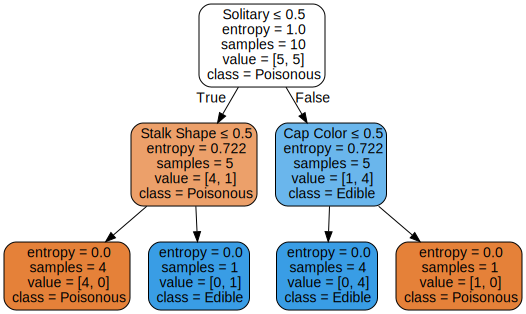

In [14]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(
    model, out_file=None, 
    feature_names=feature_names,
    class_names=class_names,
    filled=True, rounded=True,
    special_characters=True)

graph = graphviz.Source(dot_data)
graph

# Predict a new example

The final step is to apply the built tree to predict a new mushroom example.

In [15]:
new_X = np.array([['Brown','Enlarging','Yes'], ['Brown','Enlarging','No']])

###### START OF YOUR CODE ######
# Hint: Do not forget to convert the categorial feature in the same way as 
#       when you built the tree.
# Save the predictions in `new_y_preds`.
new_X_oh = np.zeros_like(new_X, dtype=int)
for c in range(new_X.shape[1]):
    new_X_oh[:,c] = label_encoders[c].transform(new_X[:,c])
new_y_preds = model.predict(new_X_oh)
###### END OF YOUR CODE ######

for i in range(len(new_X)):
    print(f"{new_X[i]}: {new_y_preds[i]}")

['Brown' 'Enlarging' 'Yes']: 1
['Brown' 'Enlarging' 'No']: 0


**Expected outputs:**
```
['Brown' 'Enlarging' 'Yes']: 1
['Brown' 'Enlarging' 'No']: 0
```